# Project: Investigating No-Show Appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> No-shows to medical appointments are an issue all over the world. They harm not only the patient, who doesn't receive any treatment or diagnosis, but they also negatively impact medical professional's schedule and ability to see more patients. If one could determine strong predictors for when a patient will no-show, special programs and focus could be put to use decreasing the no-show rate much more effectively.

> The data for this project comes from over 100,000 medical appointments in Brazil over a 3 month period. It includes whether or not the patient showed up for their appointment, as well as several other factors such as age, gender, diabetes status, and others.

In [88]:

import numpy as np
import pandas as pd
import matplotlib as plt

% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling



>The date is loaded into a pandas DataFrame and then checked for null values and duplicates. As you can see the data looks pretty well formatted already as there are no null values or duplicate rows.

>Pandas' info method shows that the data has 14 columns with 110527 entries in each column. Things of note: patient ID is stored as a float instead of an int and the scheduled day and appointment day columns are dates stored as strings. Then there are several columns stored as integers but the only values are 1 if the entry is true for the particular column, or 0 if its false. And the last column, and probably the most important, is if the patient was a no show to their appointment. It's stored as a string, either 'yes' for the patient was a no show or 'no' if the patient was not a no show.

In [89]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('noshowappointments_may_2016.csv')
print(df.info())
print('\n')
print(df.isnull().sum())
print('\n')
dupes = df.duplicated().sum()
patient_dupes = df['PatientId'].duplicated().sum()
print(f'duplicated rows: {dupes}')
print('\n')
print(f'duplicated patient id: {patient_dupes}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received

### Data Cleaning

>Column names are changed for easier use and better readability.


In [90]:
df.rename(columns = lambda x: x.lower().replace('-',''), inplace=True)
df.rename(columns={
    'patientid':'patient_id', 'appointmentid':'appt_id', 'scheduledday':'scheduled_day', 
    'appointmentday':'appt_day', 'neighbourhood':'neighborhood', 'hipertension':'hypertension', 
    'handcap':'handicapped'}, inplace=True)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id       110527 non-null float64
appt_id          110527 non-null int64
gender           110527 non-null object
scheduled_day    110527 non-null object
appt_day         110527 non-null object
age              110527 non-null int64
neighborhood     110527 non-null object
scholarship      110527 non-null int64
hypertension     110527 non-null int64
diabetes         110527 non-null int64
alcoholism       110527 non-null int64
handicapped      110527 non-null int64
sms_received     110527 non-null int64
noshow           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


>Both the 'scheduled_day' and the 'appt_day' columns are changed to pandas timestamp datatype. In the original csv file the data is stored as a string, but it's well formatted so the only line needed is pandas' to_datetime function.

In [91]:
print(df['scheduled_day'].iloc[2])
print(type(df['scheduled_day'].iloc[2]))

print(df['sms_received'].value_counts())

2016-04-29T16:19:04Z
<class 'str'>
0    75045
1    35482
Name: sms_received, dtype: int64


In [92]:
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appt_day'] = pd.to_datetime(df['appt_day'])

print(df['scheduled_day'].iloc[2])
print(type(df['scheduled_day'].iloc[2]))

2016-04-29 16:19:04
<class 'pandas._libs.tslib.Timestamp'>


>The scholarship, hypertension, diabetes, alcoholism, handicapped, and sms_received columns are all essentially True or False columns but are stored as integers with a value of 0 or 1. I changed them to bools because I think it makes more sense to have them that way.

In [93]:
bool_columns = ['scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicapped', 'sms_received']
df[bool_columns] = df[bool_columns].astype('bool')

>The last column that denotes if the patient showed up to the appointment or not is they key result I want to try and predict but it's stored as a string value: 'Yes' if the patient was a no show and 'No' if the patient was not a no show.

>I wanted to change the column from 'noshow' to 'appt_kept' because I felt there could be some confusion with double negatives (e.g., this patient was not a no-show). This also means I need to reverse all the entries so they match up with the new column title.

>A string makes it more difficult to find correlations so I changed this column to boolean values, with 'Yes' becoming False and 'No' becoming True.

In [94]:
print(df['noshow'].value_counts())
df.rename(columns = {'noshow':'appt_kept'}, inplace=True)
df['appt_kept'] = df['appt_kept'].replace({'Yes':False, 'No':True})
print(df['appt_kept'].value_counts())



No     88208
Yes    22319
Name: noshow, dtype: int64
True     88208
False    22319
Name: appt_kept, dtype: int64


<a id='eda'></a>
## Exploratory Data Analysis



### What factors are better at predicting a kept appointment?

>There are 11 factors in the table that can be directly compared to the appt_kept rate: gender of the patient, date the appointment was scheduled, date of the actual appointment, neighborhood of the hospital, age of the patient, if the patient recieved help from the Bolsa Family scholarship, if the patient had hypertension, diabetes, alcoholism, is handicapped, and if the patient had received one or more sms message from their medical provider.

>Of those, 7 are numerical or boolean and can be easily compared to if the patient kept their appointment.

In [95]:
df_num_bool = pd.concat([df.iloc[:,5],df.iloc[:,7:13]],axis=1)
appt_corr = df_num_bool.apply(lambda x: x.corr(df['appt_kept']))
print(appt_corr)

age             0.060319
scholarship    -0.029135
hypertension    0.035701
diabetes        0.015180
alcoholism      0.000196
handicapped     0.007281
sms_received   -0.126431
dtype: float64


>For this dataset, age is the only numerical category. Looking at its distribution one can see that the appointment counts are pretty evenly distributed between ages 0 and 60 and fall off after that.

Text(0.5,0,'Patient Age')

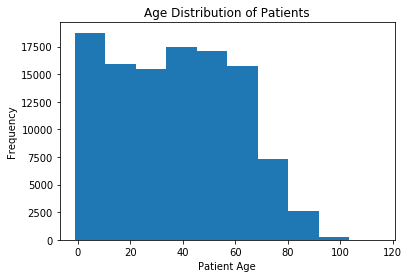

In [96]:
ax = df['age'].plot(kind='hist',title='Age Distribution of Patients');
ax.set_xlabel('Patient Age')


>For gender, I can compare the means between the male and female groups with pandas groupby function.

gender
F    0.796854
M    0.800321
Name: appt_kept, dtype: float64


Text(0,0.5,'Appointment Kept Rate')

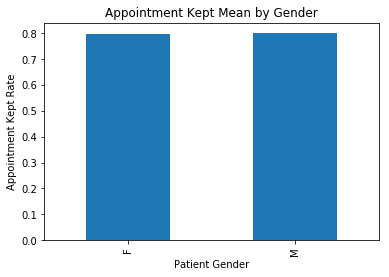

In [97]:
df_gender = df.groupby(['gender'])['appt_kept'].mean()
print(df_gender)
ax=df_gender.plot(kind='bar', title='Appointment Kept Mean by Gender')
ax.set_xlabel('Patient Gender')
ax.set_ylabel('Appointment Kept Rate')

>For neighborhoods, I started by looking at the count of each neighboor, and the mean when grouped by neighborhood. This showed the data contains 81 relevant neighborhoods.

In [98]:
neighborhood_means = df.groupby(['neighborhood'])['appt_kept'].mean().sort_values()
neighborhood_counts = df['neighborhood'].value_counts().sort_values()

print(neighborhood_means, neighborhood_counts)

neighborhood
ILHAS OCEÂNICAS DE TRINDADE    0.000000
SANTOS DUMONT                  0.710815
SANTA CECÍLIA                  0.725446
SANTA CLARA                    0.735178
ITARARÉ                        0.737336
JESUS DE NAZARETH              0.756046
HORTO                          0.760000
ILHA DO PRÍNCIPE               0.765225
CARATOÍRA                      0.769591
ANDORINHAS                     0.769673
PRAIA DO SUÁ                   0.771739
GURIGICA                       0.774034
BENTO FERREIRA                 0.775058
PARQUE MOSCOSO                 0.776808
MARUÍPE                        0.777077
DO MOSCOSO                     0.777240
ENSEADA DO SUÁ                 0.778723
ARIOVALDO FAVALESSA            0.780142
ILHA DAS CAIEIRAS              0.780579
FONTE GRANDE                   0.781525
CRUZAMENTO                     0.782546
SÃO JOSÉ                       0.783510
BARRO VERMELHO                 0.784870
NAZARETH                       0.785185
ROMÃO                      

>I put the two columns into one dataframe so the averages can be put in better context. Some of the highest outlier neighborhoods have the smallest counts meaning they're not very reliable.

In [99]:
mean_akr = df['appt_kept'].mean()
print(f'Mean appointment kept rate: {mean_akr}')
df_neighborhoods = pd.concat([neighborhood_means, neighborhood_counts], axis=1).rename(
    columns={'appt_kept':'avg_appt_kept', 'neighborhood':'appt_count'})
print(df_neighborhoods.sort_values(by=['avg_appt_kept']))


Mean appointment kept rate: 0.798067440534892
                             avg_appt_kept  appt_count
ILHAS OCEÂNICAS DE TRINDADE       0.000000           2
SANTOS DUMONT                     0.710815        1276
SANTA CECÍLIA                     0.725446         448
SANTA CLARA                       0.735178         506
ITARARÉ                           0.737336        3514
JESUS DE NAZARETH                 0.756046        2853
HORTO                             0.760000         175
ILHA DO PRÍNCIPE                  0.765225        2266
CARATOÍRA                         0.769591        2565
ANDORINHAS                        0.769673        2262
PRAIA DO SUÁ                      0.771739        1288
GURIGICA                          0.774034        2018
BENTO FERREIRA                    0.775058         858
PARQUE MOSCOSO                    0.776808         802
MARUÍPE                           0.777077        1902
DO MOSCOSO                        0.777240         413
ENSEADA DO SUÁ     

>The last two relevant columns are the datetimes when the appointment was scheduled and when the appointment actually occurred. A describe method shows that the scheduled_day column has datetime information up to the second while appt_day only has information up to the day.

>It can also be seen the oldest date in the scheduled_day column was November 2015 while for appt_day it was only as far back as April 2016. The most recent date for both columns was June 2016.

In [100]:
df.loc[:,'scheduled_day':'appt_day'].describe()


,scheduled_day,appt_day
count,110527,110527
unique,103549,27
top,2016-05-06 07:09:54,2016-06-06 00:00:00
freq,24,4692
first,2015-11-10 07:13:56,2016-04-29 00:00:00
last,2016-06-08 20:07:23,2016-06-08 00:00:00


>Using pandas datetime functionality I made new columns to explore if any particular day of the week or month of the year had higher or lower appointment kept rates.

>For the day of the week columns, there were no Sunday appointments, and many fewer appointments were scheduled on and for Saturday. This of course makes sense as doctors and hospitals typically don't schedule their appointments during the weekends.

>There's also something interesting going on with the months. For the scheduled_day column, even though data started getting collected at least by late November, there's only 61 and 60 appointments made for the months of December and January respectively. February is also pretty low compared to the summer months. 

>This is probably due to how the data was collected. Since appt_day data is only available for April 2016 through June 2016, it would make sense for those to be the most frequent months for when the appointment was scheduled as people probably schedule their appointments days to weeks and not months in advance.

In [101]:
df['scheduled_dow'] = df['scheduled_day'].dt.weekday_name
df['scheduled_month'] = df['scheduled_day'].dt.month
df['appt_dow'] = df['appt_day'].dt.weekday_name
df['appt_month'] = df['appt_day'].dt.month
sched_dow_count = df['scheduled_dow'].value_counts()
sched_month_count = df['scheduled_month'].value_counts()
appt_dow_count = df['appt_dow'].value_counts()
appt_month_count = df['appt_month'].value_counts()

>Finding the means for each day of the week and each month requires the groupby function.

In [102]:
sched_dow_mean = df.groupby(['scheduled_dow'])['appt_kept'].mean()
sched_month_mean = df.groupby(['scheduled_month'])['appt_kept'].mean()
appt_dow_mean = df.groupby(['appt_dow'])['appt_kept'].mean()
appt_month_mean = df.groupby(['appt_month'])['appt_kept'].mean()

>With the counts and means set up they can be combined into four tables and then visualized in bar graphs.

           avg_appt_kept  appt_count
Friday          0.794502       18915
Monday          0.802426       23085
Saturday        0.958333          24
Thursday        0.795275       18073
Tuesday         0.797806       26168
Wednesday       0.798904       24262


Text(0,0.5,'Appointment Kept Rate')

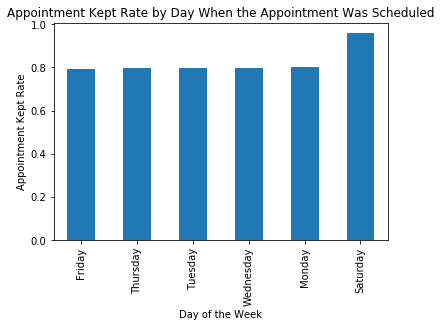

In [103]:
df_sched_dow = pd.concat([sched_dow_mean, sched_dow_count], axis=1).rename(
    columns={'appt_kept':'avg_appt_kept', 'scheduled_dow':'appt_count'})
print(df_sched_dow)
ax=df_sched_dow['avg_appt_kept'].sort_values().plot(
    kind='bar', title='Appointment Kept Rate by Day When the Appointment Was Scheduled')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Appointment Kept Rate')

>For this next graph of the appointment kept rate by month when the appointment was scheduled, I felt a line graph was better suited for the visualization. But I wanted to not include the months that had very low appointment counts because those months were probable outliers.

    avg_appt_kept  appt_count
1        0.700000          60
2        0.708185         281
3        0.669065        3614
4        0.690240       25339
5        0.825440       67421
6        0.899200       13750
11       1.000000           1
12       0.688525          61


Text(0,0.5,'Appointment Kept Rate')

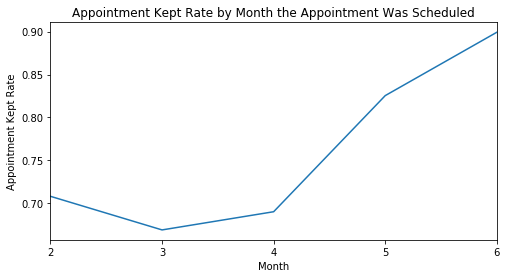

In [104]:
df_sched_month = pd.concat([sched_month_mean, sched_month_count], axis=1).rename(
    columns={'appt_kept':'avg_appt_kept', 'scheduled_month':'appt_count'})
print(df_sched_month)

ax=df_sched_month[df_sched_month['appt_count'] > 100]['avg_appt_kept'].plot(
    kind='line',
    title='Appointment Kept Rate by Month the Appointment Was Scheduled',
    figsize=(8,4),xticks=[2,3,4,5,6])
ax.set_xlabel('Month')
ax.set_ylabel('Appointment Kept Rate')



           avg_appt_kept  appt_count
Friday          0.787739       19019
Monday          0.793529       22715
Saturday        0.769231          39
Thursday        0.806459       17247
Tuesday         0.799064       25640
Wednesday       0.803108       25867


Text(0,0.5,'Appointment Kept Rate')

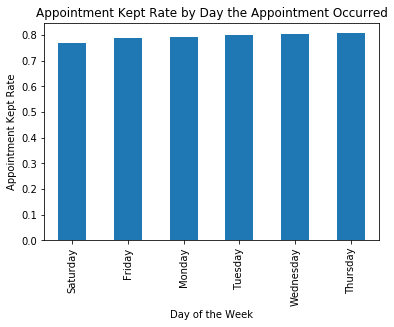

In [105]:
df_appt_dow = pd.concat([appt_dow_mean, appt_dow_count],axis=1).rename(
    columns={'appt_kept':'avg_appt_kept','appt_dow':'appt_count'})
print(df_appt_dow)
ax=df_appt_dow['avg_appt_kept'].sort_values().plot(kind='bar', title='Appointment Kept Rate by Day the Appointment Occurred')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Appointment Kept Rate')


   avg_appt_kept  appt_count
4       0.804328        3235
5       0.792135       80841
6       0.815432       26451


Text(0,0.5,'Appointment Kept Rate')

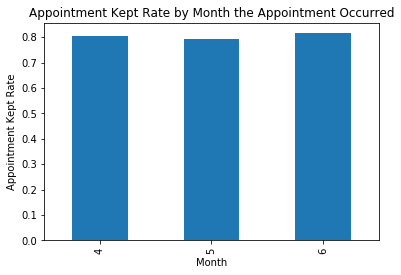

In [106]:
df_appt_month = pd.concat([appt_month_mean, appt_month_count],axis=1).rename(
    columns={'appt_kept':'avg_appt_kept', 'appt_month':'appt_count'})
print(df_appt_month)
ax=df_appt_month['avg_appt_kept'].plot(kind='bar', title='Appointment Kept Rate by Month the Appointment Occurred')
ax.set_xlabel('Month')
ax.set_ylabel('Appointment Kept Rate')

>Looking at the scheduled_day column grouped by month, there does seem to be a possibly significant pattern as May and June have visibly higher appointment kept rates than other columns (ignoring months with very low appointment counts like November and December). To investigate this further I wanted to see if maybe appointments that were scheduled closer to the actual appointment date might have fewer no-shows. 

>To do this I had to first truncate the scheduled_day column because it had higher precision than the appt_day column. After that I could subtract the two and then convert the new column into an integer so I could find the correlation between it and the appt_kept column.

In [107]:
df['scheduled_day_trunc'] = df['scheduled_day'].values.astype('<M8[D]')
df['date_diff'] = df['appt_day'] - df['scheduled_day_trunc']
type(df['date_diff'][1])
df['date_diff']=df['date_diff'].dt.days
df['date_diff'].corr(df['appt_kept'])


-0.18623082164154239

<a id='limitations'></a>
## Limitations

>This project involved a large amount of data but it did have its limitations. The major limitation is that I only used descriptive statistics and visualizations, with no inferential statistics. This means that my conclusions are suggestions based on how the data looked or the correlation values instead of any actual claims backed by p-values.

>Another limitation is that I don't know how exactly this data was collected, other than it involved appointments made in the given Brazilian neighborhoods. I'm not sure if there was any special selection of appointments, such as if certain types of appointments were ignored, or maybe certain appointment types were less likely to be collected. Because I don't know the selection process for this data, I can't really comment on any possible selection bias.

>I also don't know if this population of Brazilians who scheduled appointments fits into the general population of Brazil. This means I cannot say that this data represents the general population of Brazil and I cannot draw conclusions about the population of Brazil. I can only comment on this specific population of people that scheduled appointments, April to June, in the given Brazilian neighborhoods.

>One factor I tried to investigate was date the appointment occurred but the data was rather limited in this regard. The data only contained appointment dates for a three month period, April, May, and June, so I could not really investigate whether any month of the year had better appointment kept rates.

<a id='conclusions'></a>
## Conclusions

>Over the course of this project I looked at multiple factors to see if any one of them looked like a strong predictor for keeping a medical appointment. For age, Bolsa Familia scholarship status, hypertension status, diabetes status, alcoholism status, handicap status, and if they received any sms messages from their medical providers, I looked directly at their correlation with if their appointment was kept. For all seven of these factors, the correlation was very low, with the sms received factor being the strongest relationship with a correlation of -0.126. This indicates an extremely weak inverse relationship, and not a good way to predict no-shows.

>Other factors I looked at included gender, location (neighborhood), and date. For gender, the average kept appointment rate for women was 0.797, while for men it was 0.800. The two means being so close indicates that gender is also not a good predictor no-show status.

>Grouping by neighborhood, I saw that there were some neighborhoods associated with higher or lower no-show rates. The neighborhood Santos Dumont, which had more than 1200 appointments only had a appointment kept rate of 0.711 compared to the total average rate of 0.798. On the other end of the spectrum, Maria Cypreste had a appointment kept rate of 0.854. Without using inferential statistics though, I cannot say if either of these extremes were statistically significant and warrant further investigation.

>Lastly I looked at when the appointments were scheduled, and when the appointments were set for. I grouped both of these columns by day of the week and by month of the year. For when the appointment was scheduled, Saturdays showed a higher appointment kept rate but there were only 24 appointments in that category so that figure is probably unreliable. Grouping by month, and ignoring November, December, and January due to low appointment counts, there does seem to be a pattern. Appointments scheduled during May and June had a higher appointment kept rate. I thought that this might indicate that appointments set closer to when they were set by might have a higher appointment kept rate.

>To investigate this I did some additional data wrangling and created a new column of the number of days between when an appointment was scheduled and when it took place, stored as an integer. Then finding the correlation between that column and the appointment kept column resulted in -0.186, a stronger relationship than the one with sms message status, but still extremely weak.

>For the appointment day column, I created a table and graph for groupings by the day of the week and month of the year like I did for the scheduled day column. But all the groups had very similar means and so did not suggest any meaningful relationships to the appointment kept rate.

>My overall conclusions are that none of these factors seem like very good predictors of no-shows. For future projects I would recommend another possible factor, which would be appointment type. I would initially suggest looking at annual check up appointments, specific issue appointments, follow up appointments, therapy appointments, and addiction related appointments. Perhaps these groups might show a stronger relationship to appointment kept rates. Also, data throughout the entire year would be helpful to determine if the date when an appointment was scheduled or date when the appointment occurred are good predictors of no-shows.

In [108]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0